# Comparison: Clustered vs Standard Parameterization using XY mixer and Dicke Initialization
* This notebook uses local `qiskit.statevector_simulator` as the device to run k-Dicke initialized QAOA program with XY mixer comparing the Clustered and Standard Parameterizations on problems that are challenging for Vanilla QAOA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('custom')
from openqaoa.qaoa_parameters import PauliOp, Hamiltonian, QAOACircuitParams, create_qaoa_variational_params, QAOAVariationalStandardParams
from openqaoa.problems import Knapsack, MaximumCut, NumberPartition
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.devices import create_device
from openqaoa.qaoalib import dicke_wavefunction, dicke_basis

from openqaoa.optimizers import get_optimizer
from qiskit import QuantumCircuit
from openqaoa.utilities import *
from tqdm import tqdm

## QAOA performance on NumberPartition for ClusteredParams vs StandardParams

### Problem construction
    
* randomly initialize (or explicitly specify) a set of numbers to be partitioned
* translate the list of numbers into the QUBO form and extract the cost Hamiltonian from it
* get the exact solution of the problem by calling the `ground_state_hamiltonian` function 
* Initialize the mixer of choice to be used in the QAOA routine

In [2]:
nums=list(np.random.randint(0,200,9))
cost_prob = NumberPartition(nums).get_qubo_problem()
cost_hamil = cost_prob.hamiltonian
n_qubits = cost_hamil.n_qubits

In [3]:
#print the solution to the problem
print(ground_state_hamiltonian(cost_hamil))

(4.0, ['100011010', '011100101'])


In [4]:
mixer_hamil_xy = XY_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'],qubit_connectivity='full')
mixer_hamil_x = X_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'])

### Construct workflow objects
* Create the QAOACircuitParams object -> responsible for the creating the abstract QAOA circuit from cost and mixer Hamiltonians
* Create and initialize the chosen Variational Parameters (for this notebook, we choose to compare Standard vs Clustered params)
* Create the backend object with prepend_states and the chosen device 

In [5]:
p=4
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_x, p=p)

In [6]:
max_std_dev=2
variate_params_clustered = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev=max_std_dev)
variate_params_standard = create_qaoa_variational_params(circuit_params,'standard','ramp')

In [7]:
k_excitations = 3
prepend_state = dicke_wavefunction(k_excitations,n_qubits = n_qubits)
init_hadamard = False

In [13]:
device = create_device('local','vectorized')
backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=init_hadamard)

### Prepare the Optimizer to work with Variational Params and Backend
* specify optimization method and maxiters
* create different optimizer objects for clustered and standard params
* Perform the optimization

In [14]:
optimizer_dict = {'method': 'cobyla', 'maxiter': 2000}

In [15]:
optimizer_obj_standard = get_optimizer(backend_obj, variate_params_standard, optimizer_dict)
optimizer_obj_clustered = get_optimizer(backend_obj, variate_params_clustered, optimizer_dict)

In [16]:
optimizer_obj_standard
optimizer_obj_clustered

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 2000

In [17]:
%%time
optimizer_obj_standard()

CPU times: user 782 ms, sys: 21.1 ms, total: 803 ms
Wall time: 800 ms


Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 2000

In [18]:
%%time
optimizer_obj_clustered()

CPU times: user 9min 57s, sys: 1.98 s, total: 9min 59s
Wall time: 10min 2s


Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 2000

### Extract Results from the optimization runs
* Since this notebook compares the Clustered and Standard Parameterizations, extract the results obtained from the two optimization runs for comparison
* Plot cost history, probability overlap with low energy states, probability distribution over basis states

In [25]:
results_clustered = optimizer_obj_clustered.qaoa_result
cost_history_clustered = results_clustered.intermediate['intermediate cost']

In [26]:
results_standard = optimizer_obj_standard.qaoa_result
cost_history_standard = results_standard.intermediate['intermediate cost']

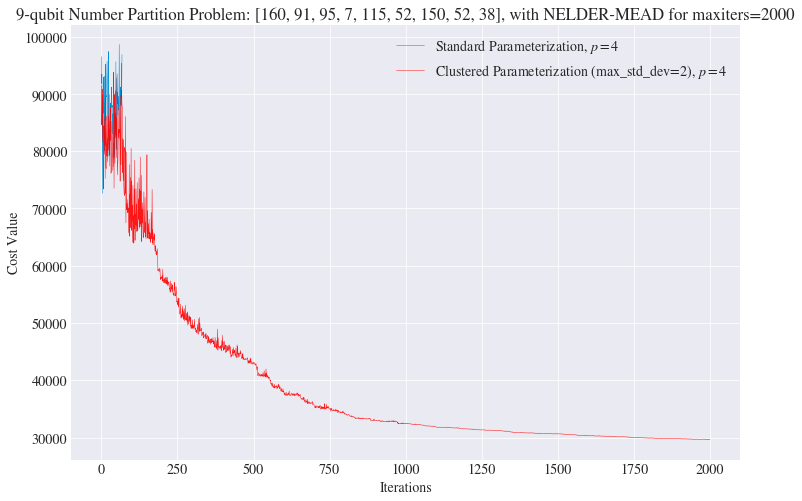

In [29]:
plt.plot(cost_history_standard,label=f'Standard Parameterization, $p={p}$',lw=0.5)
plt.plot(cost_history_clustered, color='red',label=f'Clustered Parameterization (max_std_dev={max_std_dev}), $p={p}$',lw=0.5,alpha=0.9)
# plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost Value')
plt.legend();
plt.title(f'9-qubit Number Partition Problem: {nums}, with NELDER-MEAD for maxiters=2000');
# plt.savefig(f'images/9-qubit Number Partition Problem: {nums}.pdf')

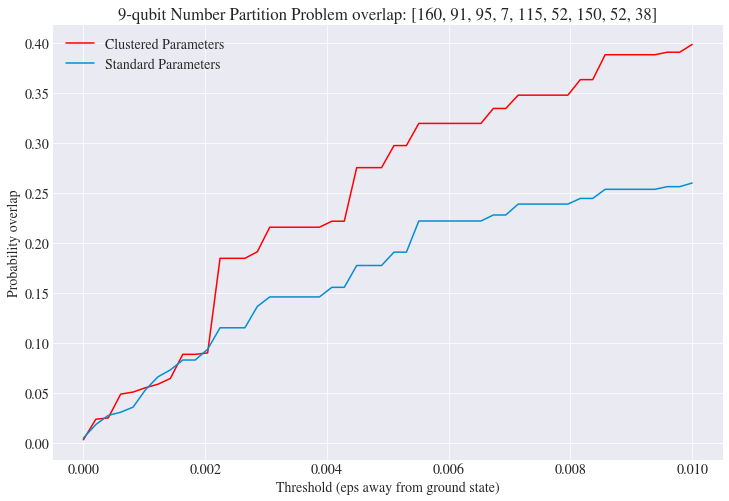

In [36]:
counts_dict_clustered = results_clustered.get_counts(results_clustered.optimized['optimized measurement outcomes'])
counts_dict_standard = results_standard.get_counts(results_standard.optimized['optimized measurement outcomes'])

eps = np.linspace(0,0.01,50)
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered) for ep in eps],color='red')
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_standard) for ep in eps])
plt.legend(['Clustered Parameters','Standard Parameters'])
plt.xlabel('Threshold (eps away from ground state)')
plt.ylabel('Probability overlap')
plt.title(f'9-qubit Number Partition Problem overlap: {nums}');
# plt.savefig(f'images/9-qubit Number Partition Problem overlap: {nums}.pdf')

In [33]:
counts_dict_standard_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_standard)
counts_dict_clustered_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_clustered)

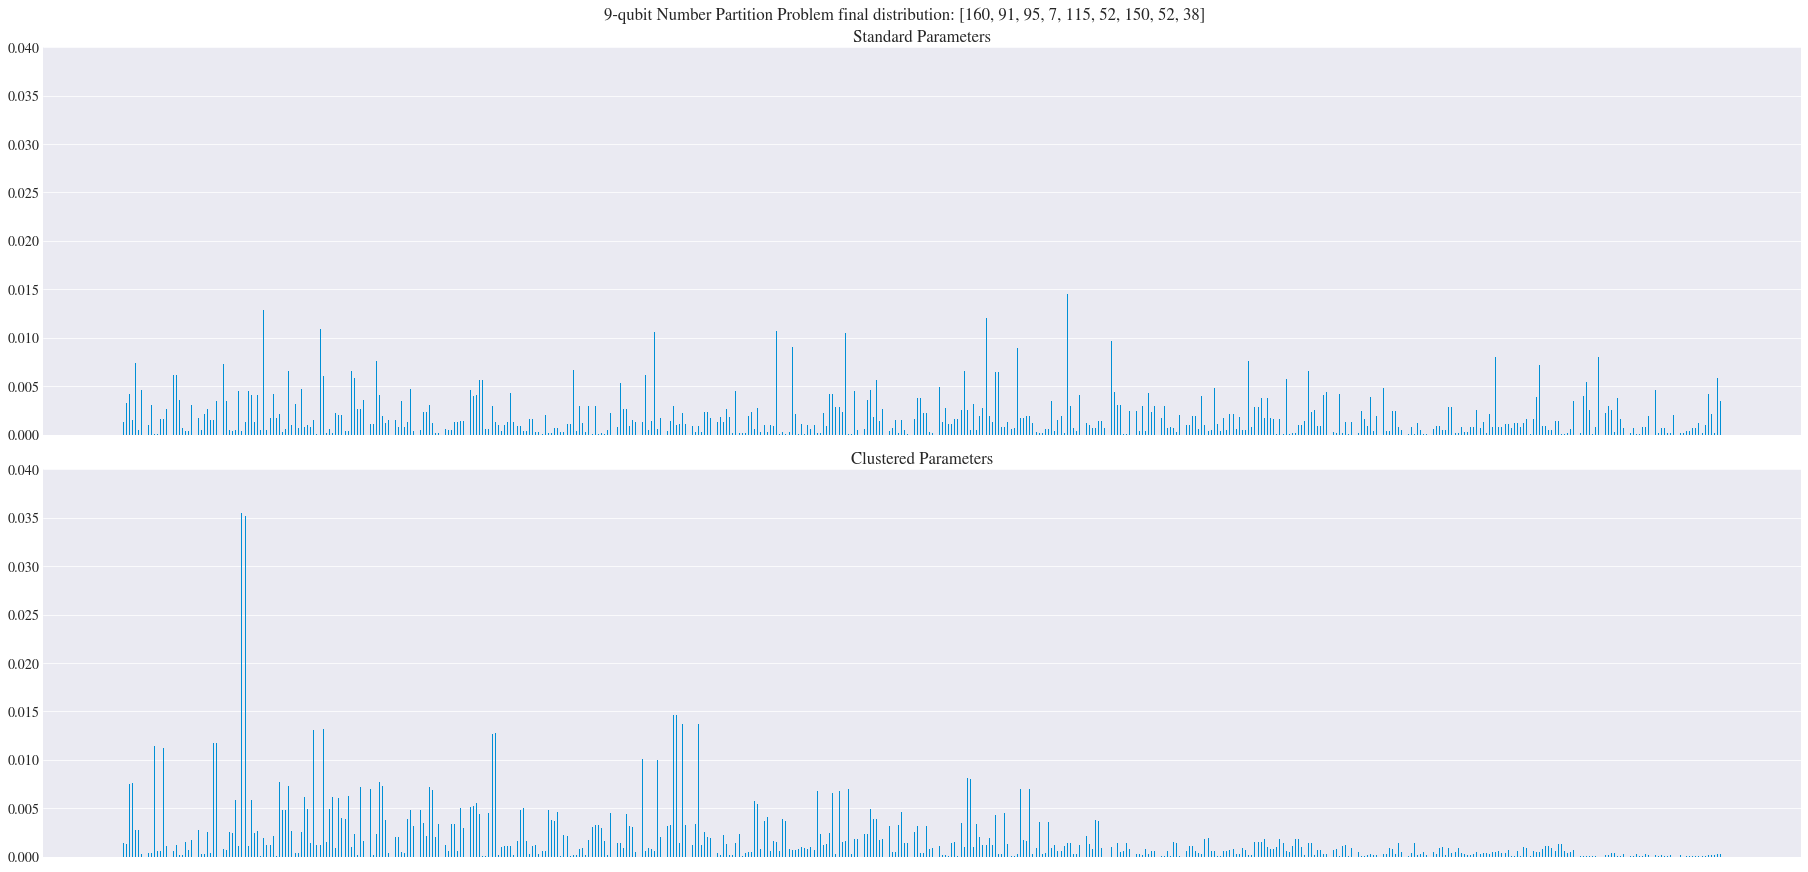

In [43]:
fig,axes = plt.subplots(2,1,figsize=(25,12),constrained_layout=True,sharey=True,sharex=True)
plot_counts(counts_dict_standard_sorted,False,axes[0])
plot_counts(counts_dict_clustered_sorted,False,axes[1])
axes[0].set_title('Standard Parameters')
axes[1].set_title('Clustered Parameters');
plt.suptitle(f'9-qubit Number Partition Problem final distribution: {nums}');
plt.ylim([0,0.04]);
# plt.savefig(f'images/9-qubit Number Partition Problem final energy distribution: {nums}.pdf')

## On average performance for StandardParams vs ClusteredParams with XY-mixer and Dicke warm-starting

Compare performance of QAOA optimization on random_instances of NumberPartition problems on 7 qubits

### Construct a set of randomly generated problems

Construct the cost Hamiltonian and the mixer Hamiltonian

In [44]:
total_probs = 5
np_probs = []
np_qubos = []
n_items = 7
np.random.seed(5678)
for i in tqdm(range(total_probs)):
    nums=list(np.random.randint(0,200,n_items))
    prob = NumberPartition(nums)
    np_probs.append(prob)
    np_qubos.append(prob.get_qubo_problem())
    
n_qubits = n_items

100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2480.08it/s]


In [45]:
#cost Hamiltonian
cost_hamils = [qubo.hamiltonian for qubo in np_qubos]

# X-mixer and XY-mixer Hamiltonians
mixer_hamil_xy = XY_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'],qubit_connectivity='full')
mixer_hamil_x = X_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'])

In [46]:
#helper function to compute the excitations in ground state solutions
def excitations_ground_state(hamiltonian):
    """
    Compute the number of excitations in ground-state of Hamiltonian.
    NOTE: Since the problem is Z2-symmetric, the ground-state is doubly
    degenerate and will have both `x` excitations and `n-x` excitations
    where `n` is the number of qubits
    
    Parameters
    ----------
    hamiltonian: Hamiltonian
        The Cost Hamiltonian for which to calculate the ground state 
        excitations number
    """
    
    energy, configs = ground_state_hamiltonian(hamiltonian)
    
    # w.l.o.g pick the first config
    state = configs[0]
    excitations = np.sum([int(i) for i in state])
    return excitations

In [47]:
excitations_hamiltonians = [excitations_ground_state(hamil) for hamil in cost_hamils]

### Construct workflow objects
* Create the QAOACircuitParams object -> responsible for the creating the abstract QAOA circuit from cost and mixer Hamiltonians
* Create and initialize the chosen Variational Parameters (for this notebook, we choose to compare Standard vs Clustered params)
* Create the backend object with prepend_states and the chosen device 

In [48]:
optimizer_dict = {'method': 'SPSA', 'maxiter': 1000, 'optimization_progress':True, 'jac':'finite_difference'}
    
optimizer_obj_standard = get_optimizer(backend_obj, variate_params_standard, optimizer_dict)
    
optimizer_dict.get('method',None)
optimizer_dict

{'method': 'SPSA', 'maxiter': 1000, 'optimization_progress': True}

In [56]:
p=4
max_std_dev=2

workflows = []
device = create_device('local','vectorized')

for i,cost_hamil in enumerate(tqdm(cost_hamils)):
    #using the XY-mixer
    circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_xy, p=p)

    variate_params_clustered = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev=max_std_dev)
    variate_params_standard = create_qaoa_variational_params(circuit_params,'standard','ramp')
    
    prepend_state = dicke_wavefunction(excitations_hamiltonians[i],n_qubits = n_qubits)
    backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=False)
    
    optimizer_dict = {'method': 'COBYLA', 'maxiter': 1000, 'optimization_progress':True, 'jac':'finite_difference'}
    
    optimizer_obj_standard = get_optimizer(backend_obj, variate_params_standard, optimizer_dict)
    
    optimizer_dict = {'method': 'COBYLA', 'maxiter': 1000, 'optimization_progress':True, 'jac':'finite_difference'}
    
    optimizer_obj_clustered = get_optimizer(backend_obj, variate_params_clustered, optimizer_dict)
    
    #run standard optimization
    optimizer_obj_standard.optimize()
    
    #run clustered optimization
    optimizer_obj_clustered.optimize()
    
    results_std = optimizer_obj_standard.qaoa_result
#     results_clustered = optimizer_obj_clustered.qaoa_result
    
    save_dict = { 'cost_hamil':cost_hamil,
                  'circuit_params':circuit_params,
                  'clustered_params':variate_params_clustered,
                  'standard_params':variate_params_standard,
                  'prepend_state':prepend_state,
                  'backend_obj':backend_obj,
                  'results_std':results_std,
                  'results_clustered':results_clustered }
    
    workflows.append(save_dict)

100%|████████████████████████████████████████████████████████████████| 5/5 [08:46<00:00, 105.30s/it]


In [57]:
results_std_list = [workflow['results_std'] for workflow in workflows]

In [58]:
results_clustered_list = [workflow['results_clustered'] for workflow in workflows]

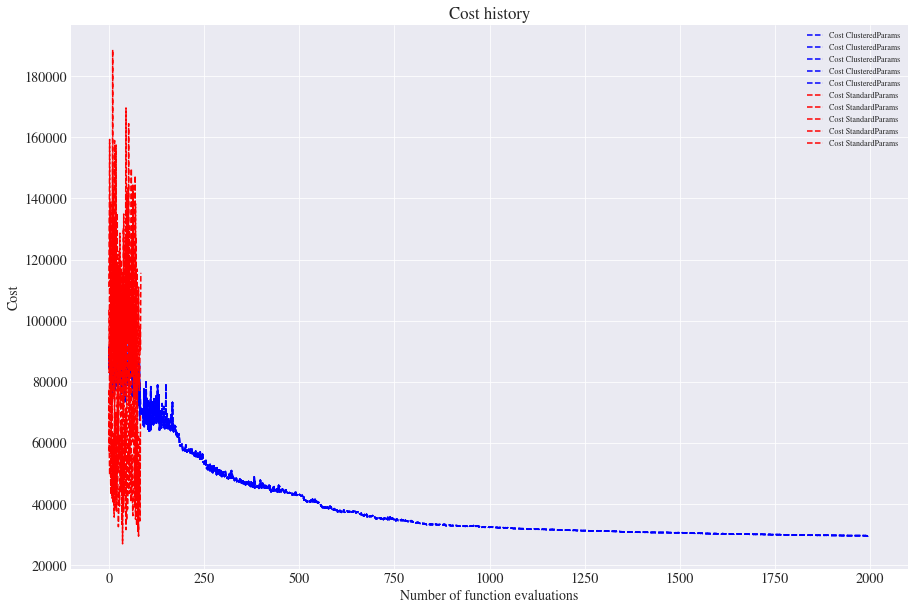

In [60]:
fig,ax=plt.subplots(1,1,figsize=(15,10))
[result.plot_cost(ax=ax,label='Cost ClusteredParams') for result in results_clustered_list];
[result.plot_cost(ax=ax,color='red',label='Cost StandardParams') for result in results_std_list];
ax.legend(prop={'size':8})
# ax.set_xscale('log')

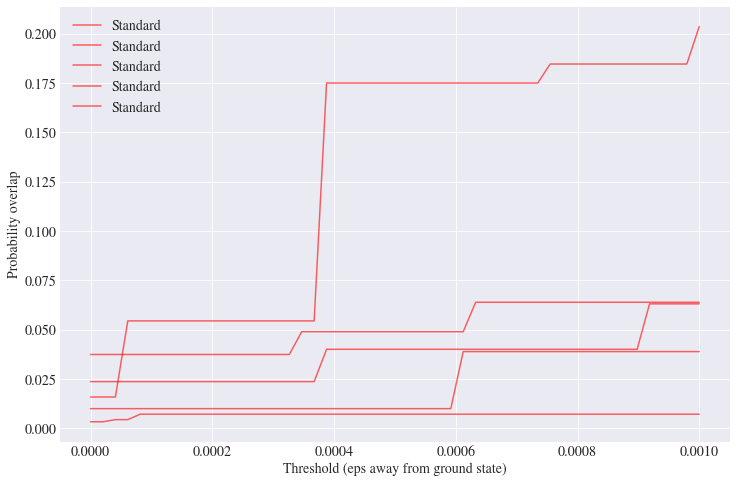

In [80]:
counts_dict_clustered_list=[]
counts_dict_standard_list=[]
for i in range(len(results_std_list)):

    counts_dict_clustered_list.append(results_clustered_list[i].get_counts(results_clustered_list[i].optimized['optimized measurement outcomes']))
    counts_dict_standard_list.append(results_std_list[i].get_counts(results_std_list[i].optimized['optimized measurement outcomes']))

for i in range(len(counts_dict_clustered_list)):
    eps = np.linspace(0,0.001,50)
#     plt.plot(eps, [low_energy_states_overlap(cost_hamils[i], ep, counts_dict_clustered_list[i]) for ep in eps],color='blue',alpha=0.5,label='Clustered')
    plt.plot(eps, [low_energy_states_overlap(cost_hamils[i], ep, counts_dict_standard_list[i]) for ep in eps],color='red',alpha=0.6,label='Standard')
    plt.legend();
    plt.xlabel('Threshold (eps away from ground state)')
    plt.ylabel('Probability overlap')
    #     plt.title(f'9-qubit Number Partition Problem overlap: {nums}');
    # plt.savefig(f'images/9-qubit Number Partition Problem overlap: {nums}.pdf')

In [79]:
results_std_list[0].get_counts(results_std_list[0].optimized['optimized measurement outcomes'])

{'0000000': 0.0005294479300515869,
 '1000000': 0.0,
 '0100000': 0.0,
 '1100000': 0.0010936373391126383,
 '0010000': 0.0,
 '1010000': 0.0003405221787366612,
 '0110000': 0.0006549402962529171,
 '1110000': 0.0,
 '0001000': 0.0,
 '1001000': 0.0029516165962951138,
 '0101000': 0.000682775848433454,
 '1101000': 0.0,
 '0011000': 0.0036553873243490792,
 '1011000': 0.0,
 '0111000': 0.0,
 '1111000': 0.004997279350413219,
 '0000100': 0.0,
 '1000100': 0.01368062901046454,
 '0100100': 0.026683235590861,
 '1100100': 0.0,
 '0010100': 0.006032571596133516,
 '1010100': 0.0,
 '0110100': 0.0,
 '1110100': 0.04571677058001837,
 '0001100': 0.0010108555722532558,
 '1001100': 0.0,
 '0101100': 0.0,
 '1101100': 0.012406851686918925,
 '0011100': 0.0,
 '1011100': 0.042564500367141773,
 '0111100': 0.028370960558413268,
 '1111100': 0.0,
 '0000010': 0.0,
 '1000010': 0.0012160425073759792,
 '0100010': 0.014516743911026867,
 '1100010': 0.0,
 '0010010': 0.011427770805991102,
 '1010010': 0.0,
 '0110010': 0.0,
 '1110010':